In [16]:
from fastai import *
from fastai.vision import *

from astroML.crossmatch import crossmatch_angular
from astropy.coordinates import matching, SkyCoord
import astropy.units as u

PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# SDSS catalog

In [4]:
sdss = pd.read_csv(f"{PATH}/data/SDSS_basic_data.csv")
sdss.columns

Index(['objID', 'DR7ObjID', 'specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp',
       'velDispErr', 'modelMag_u', 'modelMagErr_u', 'modelMag_g',
       'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i',
       'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r',
       'petroR90_r', 'bptclass', 'oh_p16', 'oh_p50', 'oh_p84', 'lgm_tot_p16',
       'lgm_tot_p50', 'lgm_tot_p84', 'sfr_tot_p16', 'sfr_tot_p50',
       'sfr_tot_p84'],
      dtype='object')

In [32]:
alf = pd.read_csv(f"{PATH}/data/a100.code12.tab1.180315.csv", index_col='AGCNr')
alf.columns

Index(['Name', 'RAdeg_HI', 'DECdeg_HI', 'RAdeg_OC', 'DECdeg_OC', 'Vhelio',
       'W50', 'sigW', 'W20', 'HIflux', 'sigflux', 'SNR', 'RMS', 'Dist',
       'sigDist', 'logMH', 'siglogMH', 'HIcode'],
      dtype='object')

## Remove self-matches within 55" (possible SDSS fiber collisions)

In [18]:
sdss_coords = SkyCoord(sdss[['ra', 'dec']].values * u.deg)

In [25]:
len(sdss)

717778

In [20]:
ind, sep2d, _ = matching.match_coordinates_sky(
    sdss_coords,
    sdss_coords,
    nthneighbor=2,
)

In [27]:
sum(sep2d < 55*u.arcsec)

44349

In [30]:
sdss = sdss[sep2d > 55*u.arcsec]
len(sdss)

673429

In [31]:
sdss_coords = SkyCoord(sdss[['ra', 'dec']].values * u.deg)

## Remove HI detections within beam radius (1.9')

In [34]:
alf_coords = SkyCoord(alf[['RAdeg_HI', 'DECdeg_HI']].values * u.deg)

In [36]:
ind, sep2d, _ = matching.match_coordinates_sky(
    sdss_coords,
    alf_coords,
    nthneighbor=1,
)

In [37]:
sum(sep2d < 1.9*u.arcmin)

22142

In [38]:
sdss = sdss[sep2d > 1.9*u.arcmin]
len(sdss)

651287

## Remove low-mass galaxies (< $10^8 M_*$)

In [39]:
sum(sdss.lgm_tot_p50 < 8)

71972

In [40]:
sdss = sdss[sdss.lgm_tot_p50 > 8]

## Remove z > 0.059 galaxies

In [58]:
sum(sdss.z < 0.059)

88023

In [59]:
sdss = sdss[sdss.z < 0.059]

## Check SDSS vs ALFALFA footprint

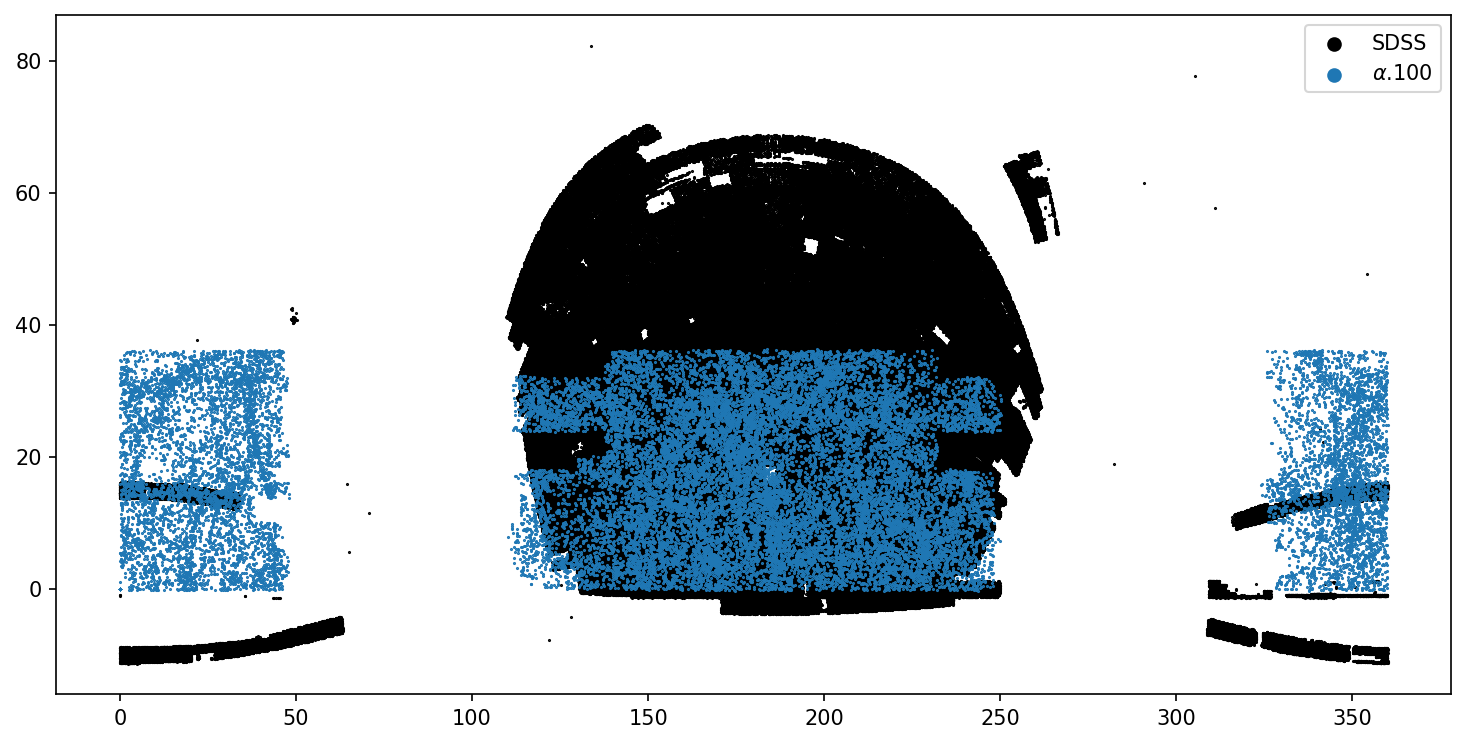

In [42]:
plt.figure(figsize=(12, 6), dpi=150)
# plt.scatter(a100_orig.RAdeg_OC, a100_orig.DECdeg_OC, c='k', marker='.', s=5,  label=r'$\alpha$.100 (original)')
plt.scatter(sdss.ra, sdss.dec, c='k', marker='.', s=1, label=r'SDSS')
plt.scatter(alf.RAdeg_OC, alf.DECdeg_OC, c='C0', marker='.', s=1,  label=r'$\alpha$.100')
plt.legend(markerscale=12)

## A still-large sample of nondetections
To simplify the footprint, a bit, I'll only use galaxies in a smaller box: 150 < RA < 220 and 1 < DEC < 35

In [60]:
# nondetections
in_box = (150 < sdss.ra) & (sdss.ra < 220) & (1 < sdss.dec) & (sdss.dec < 35)
nd = sdss[in_box]
sum(in_box)

23702

## save as a100 nondetections

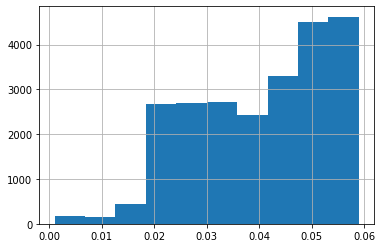

In [63]:
nd.z.hist()

In [64]:
nd.to_csv(f'{PATH}/results/nondetections/a100-nd_himass_lowz.csv', index=False)